In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
import cv2

### Importowanie danych

In [2]:
data = np.load("./olivetti_faces.npy")
target = []

for i in range(40):
    target.extend([i for _ in range(10)])

### Prezentacja 40 unikalnych osób

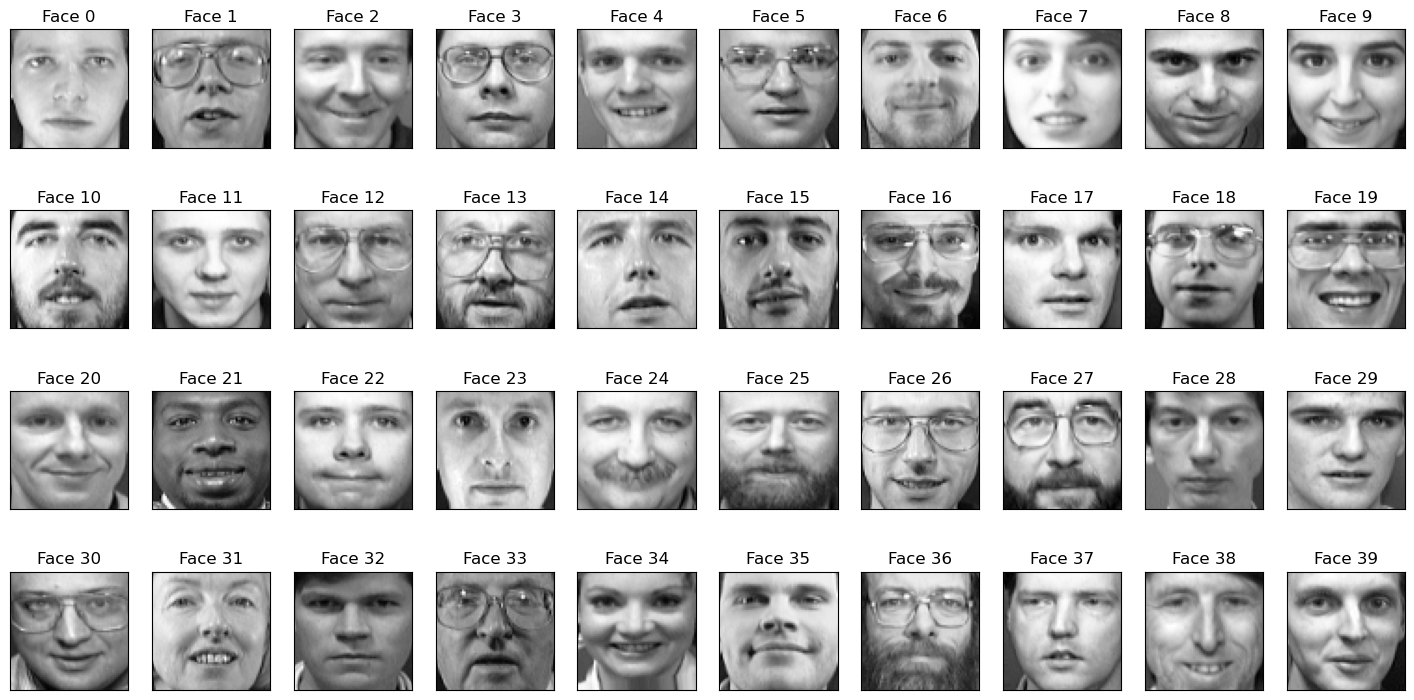

In [3]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(data[i * 10], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Przykład twarzy dla trzech wybranych osób

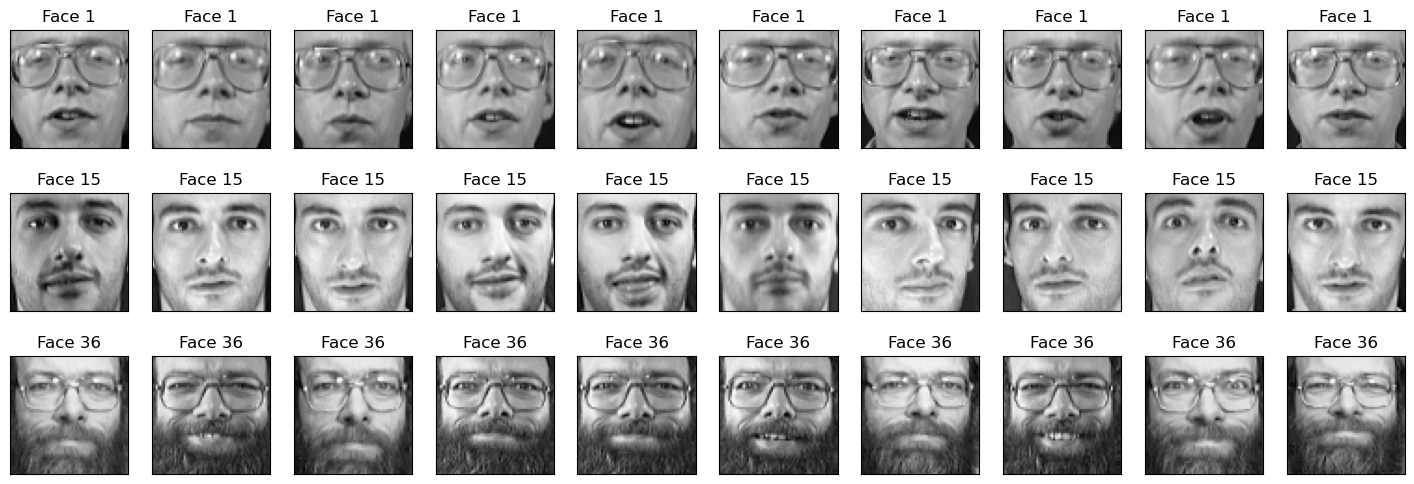

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))

ids = [1, 15, 36]

for i in range(len(ids)):
    for j in range(10):
        ax[i, j].imshow(data[ids[i] * 10 + j], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"Face {ids[i]}")

### Zamiana zdjęć na wektory cech

In [5]:
feature_vectors = data.reshape((data.shape[0], 64 * 64))
feature_vectors.shape

(400, 4096)

### Podział na dane treningowe i dane testowe

In [6]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                    random_state=42, stratify=target)
X_train.shape

(280, 4096)

## Eigenfaces

### Obliczenie twarzy średniej

In [7]:
mean_face = np.mean(X_train, axis=0)

Text(0.5, 1.0, 'Twarz średni')

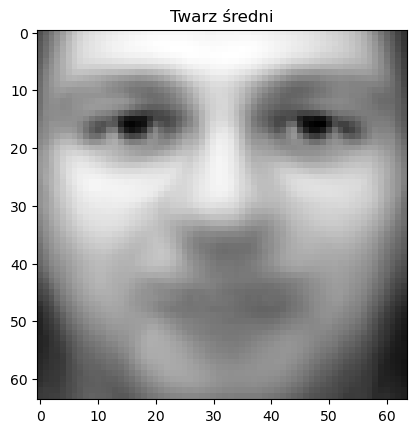

In [8]:
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title(f"Twarz średni")

### Odjęcie twarzy średniej od twarzy treningowych

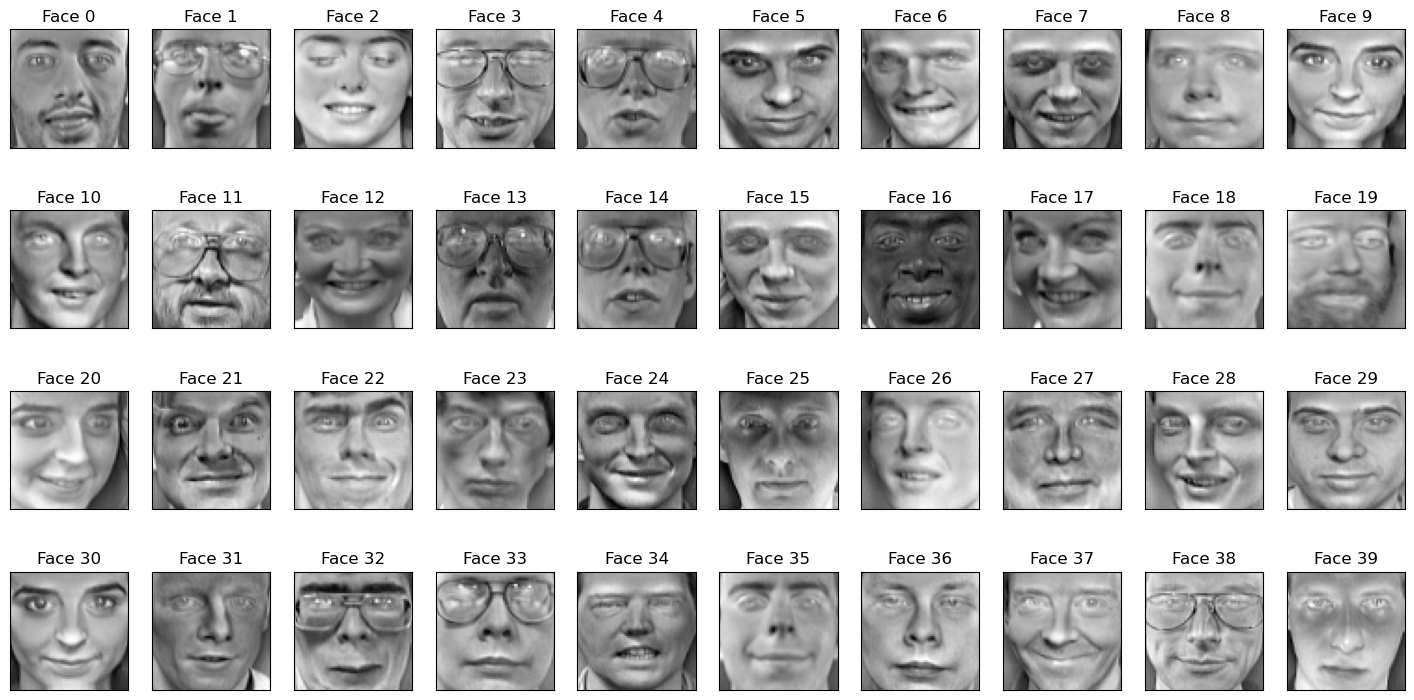

In [9]:
feature_vectors_subtracted = X_train - mean_face

fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(feature_vectors_subtracted[i * 7].reshape(64, 64), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Obliczenie macierzy kowariancji

In [10]:
covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))
covariance_matrix.shape

(280, 280)

### Obliczenie wartości i wektorów własnych

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
_, eigenvectors_sort = zip(*eig_pairs)
eigenvectors_sort = np.array(eigenvectors_sort)[:100]

eigenvectors_sort.shape

(100, 280)

In [12]:
eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
eigenfaces.shape

(100, 4096)

### Wyświetlenie wszystkich twarzy własnych

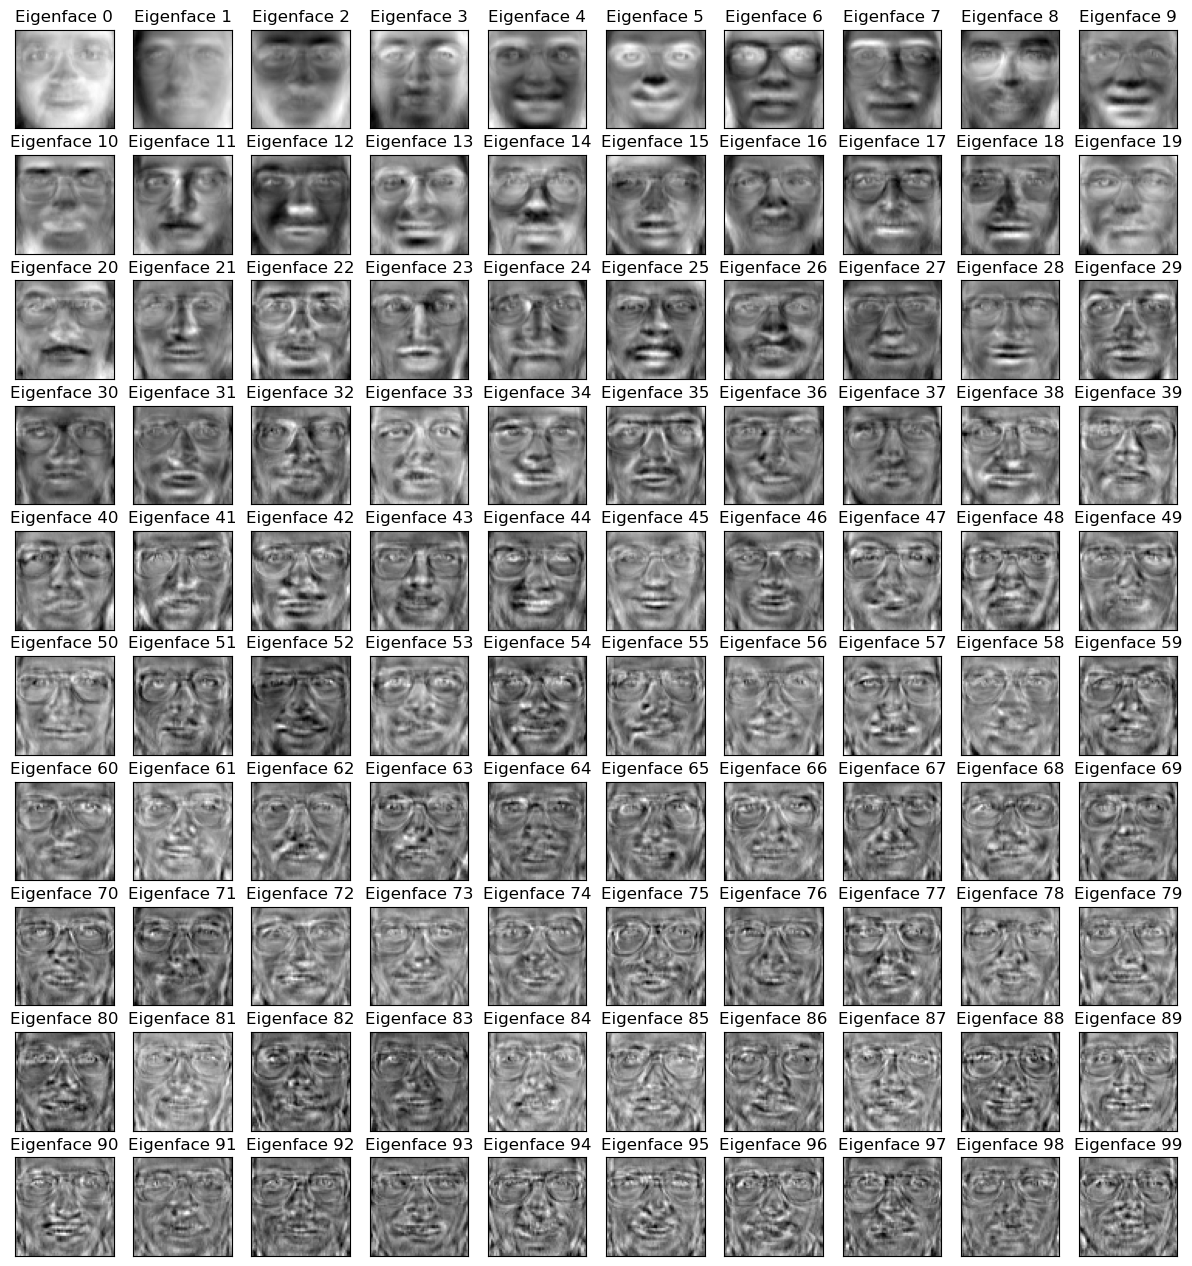

In [13]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 16))
ax = ax.flatten()
for i in range(len(eigenfaces)):
    ax[i].imshow(eigenfaces[i].reshape(64, 64), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Eigenface {i}")

### Projekcja wektorów cech na nową przestrzeń

In [14]:
transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
transformed_faces.shape

(280, 100)

### Rozpoznawanie twarzy (istniejące zdjęcie w bazie)

In [15]:
subtracted_vector = X_train[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

epsilon: 1.1386189e-05


### Rekonstrukcja twarzy

Text(0.5, 1.0, 'Twarz odtworzona')

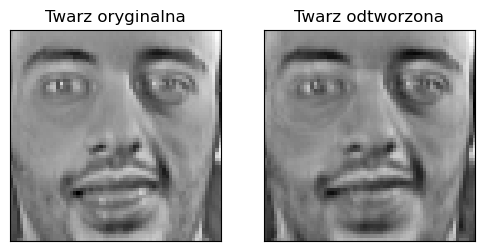

In [16]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (nowe zdjęcie osoby istniejącej w bazie)

In [17]:
subtracted_vector = X_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

epsilon: 2.633781


### Rekonstrukcja twarzy

Text(0.5, 1.0, 'Twarz odtworzona')

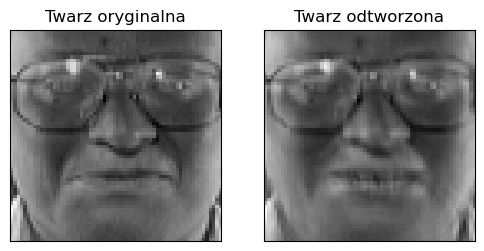

In [18]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Reakcja na zdjęcie kota

epsilon: 11203.532


Text(0.5, 1.0, 'Twarz odtworzona')

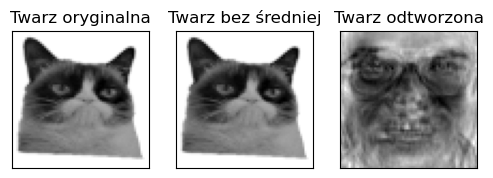

In [19]:
cat = cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE)

subtracted_vector = np.reshape(cat, 64*64) - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
ax[0].imshow(cat, cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz bez średniej")

ax[2].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title(f"Twarz odtworzona")

### Reakcja na zdjęcie jabłka

epsilon: 12901.122


Text(0.5, 1.0, 'Twarz odtworzona')

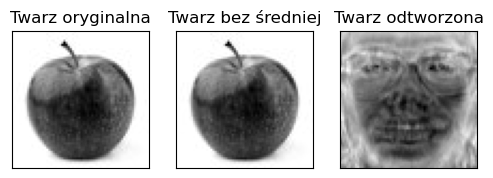

In [20]:
apple = cv2.imread('apple.png', cv2.IMREAD_GRAYSCALE)

subtracted_vector = np.reshape(apple, 64*64) - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
ax[0].imshow(apple, cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz bez średniej")

ax[2].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki najbliższy sąsiad

In [21]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 2

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) > theta):
        errors += 1
        continue

    if (y_train[np.argmin(epsilon)] != y_test[i]):
        errors += 1

print(f"Statystyka: {len(y_test) - errors}/{len(y_test)} poprawnych")

Statystyka: 111/120 poprawnych


### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki K najbliższych sąsiadów

In [22]:
errors = 0

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))
    
    epsilon_sorted_indexes = np.argsort(epsilon)[:7]
    values = [y_train[index] for index in epsilon_sorted_indexes]
    
    counts = Counter(values)
    max_count = max(counts.values())
   
    if max_count >= 4:
        for value, count in counts.items():
            if count == max_count:
                if(value != y_test[i]):
                    errors +=1
    else:
        errors +=1 
                    
print(f"Statystyka: {len(y_test)-errors}/{len(y_test)} poprawnych") 

Statystyka: 65/120 poprawnych


## Eigenfaces na ograniczonej liczbie osob

### Przygotowanie danych

In [23]:
data = np.load("./olivetti_faces.npy")

unique_ids = [i for i in range(40)]

id_train, id_test = train_test_split(unique_ids, test_size=0.5, random_state=42)

data_selected = []
for i in id_train:
    for j in range(10):
        data_selected.append(data[i*10+j])
        
data_selected_test = []
for i in id_test:
    for j in range(10):
        data_selected_test.append(data[i*10+j])
        
data_selected_test = np.array(data_selected_test).reshape((np.array(data_selected_test).shape[0], 64 * 64))

target = []
for i in id_train:
    target.extend([i for _ in range(10)])
    
target_test = []
for i in id_test:
    target_test.extend([i for _ in range(10)])

### Prezentacja unikalnych osób

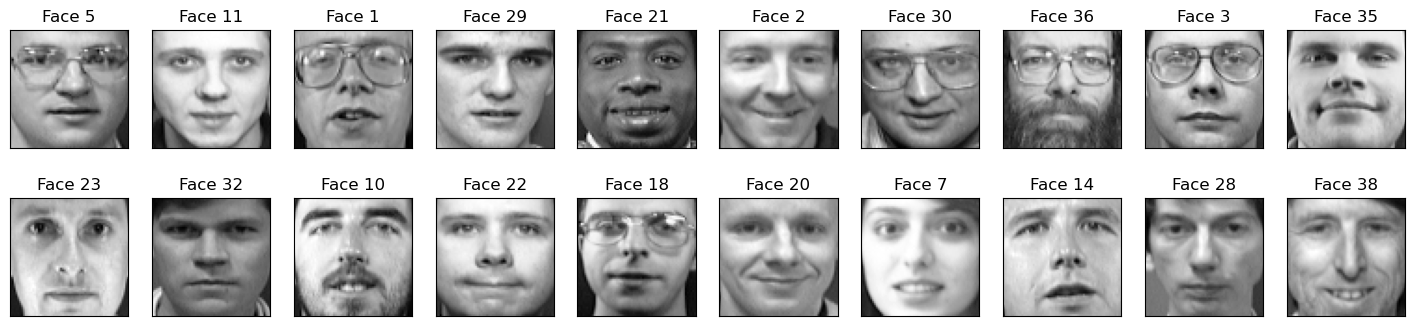

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(18, 4))
ax = ax.flatten()

for i in range(len(id_train)):
    ax[i].imshow(data_selected[i * 10], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {id_train[i]}")

### Zamiana zdjęć na wektory cech

In [25]:
feature_vectors = np.array(data_selected).reshape((np.array(data_selected).shape[0], 64 * 64))
feature_vectors.shape

(200, 4096)

### Podział na dane treningowe i testowe

In [26]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                    random_state=42, stratify=target)
X_train.shape

(140, 4096)

### Twarz średnia

Text(0.5, 1.0, 'Twarz średni')

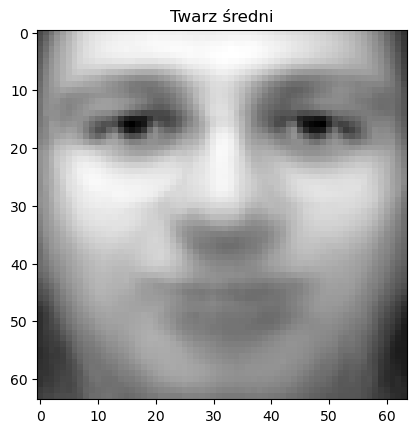

In [27]:
mean_face = np.mean(X_train, axis=0)
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title(f"Twarz średni")

### Macierz kowariancji

In [28]:
feature_vectors_subtracted = X_train - mean_face
covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))
covariance_matrix.shape

(140, 140)

### Wartości i wektory własne

In [29]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
_, eigenvectors_sort = zip(*eig_pairs)
eigenvectors_sort = np.array(eigenvectors_sort)[:100]

eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
eigenfaces.shape

(100, 4096)

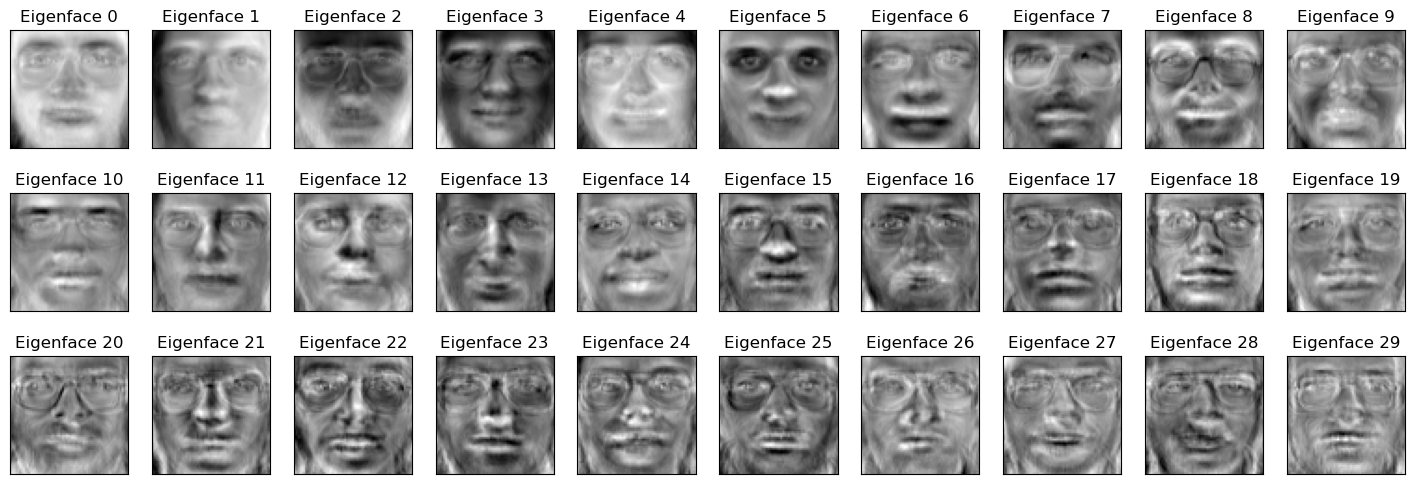

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))
ax = ax.flatten()
for i in range(30):
    ax[i].imshow(eigenfaces[i].reshape(64, 64), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Eigenface {i}")

### Projekcja wektorów cech

In [31]:
transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
transformed_faces.shape

(140, 100)

## Rozpoznawanie twarzy

epsilon zdjęcia istniejącego w bazie: 6.829774e-06


Text(0.5, 1.0, 'Twarz odtworzona')

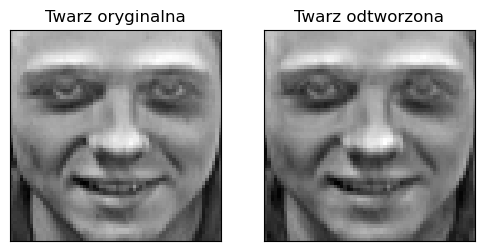

In [32]:
subtracted_vector = X_train[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon zdjęcia istniejącego w bazie: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

epsilon zdjęcia osoby istniejącej w bazie: 1.3382595


Text(0.5, 1.0, 'Twarz odtworzona')

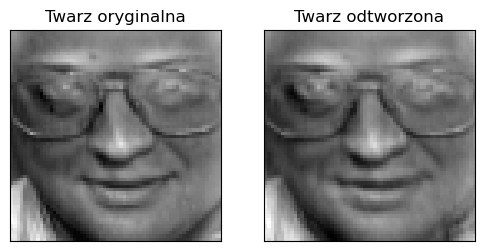

In [33]:
subtracted_vector = X_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon zdjęcia osoby istniejącej w bazie: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (osoba nie istnieje w bazie)

In [34]:
subtracted_vector = data_selected_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

epsilon: 6.1435647


Text(0.5, 1.0, 'Twarz odtworzona')

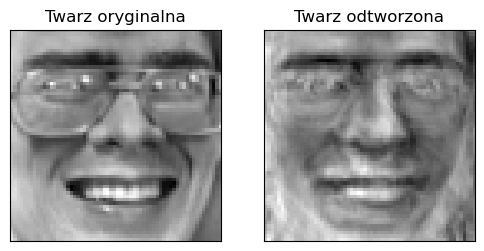

In [35]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki najbliższy sąsiad

In [36]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 3

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) > theta):
        errors += 1
        continue

    if (y_train[np.argmin(epsilon)] != y_test[i]):
        errors += 1

print(f"Statystyka: {len(y_test) - errors}/{len(y_test)} poprawnych")

Statystyka: 59/60 poprawnych


### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki K najbliższych sąsiadów

In [37]:
errors = 0

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))
    
    epsilon_sorted_indexes = np.argsort(epsilon)[:7]
    values = [y_train[index] for index in epsilon_sorted_indexes]
    
    counts = Counter(values)
    max_count = max(counts.values())
   
    if max_count >= 4:
        for value, count in counts.items():
            if count == max_count:
                if(value != y_test[i]):
                    errors +=1
    else:
        errors +=1 
                    
print(f"Statystyka: {len(y_test)-errors}/{len(y_test)} poprawnych") 

Statystyka: 45/60 poprawnych


### Rozpoznawanie twarzy (osoba nie istniejąca w bazie) - statystyki najbliższy sąsiad

In [38]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 4

for i, face in enumerate(data_selected_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) < theta):  
        errors += 1

print(f"Statystyka: {len(target_test) - errors}/{len(target_test)} poprawnych")

Statystyka: 168/200 poprawnych


## Eigenfaces na ograniczonej liczbie osob

### Przygotowanie danych

In [39]:
data = np.load("./olivetti_faces.npy")

unique_ids = [i for i in range(40)]

id_train, id_test = train_test_split(unique_ids, test_size=0.97, random_state=42)

data_selected = []
for i in id_train:
    for j in range(10):
        data_selected.append(data[i*10+j])
        
data_selected_test = []
for i in id_test:
    for j in range(10):
        data_selected_test.append(data[i*10+j])
        
data_selected_test = np.array(data_selected_test).reshape((np.array(data_selected_test).shape[0], 64 * 64))

target = []
for i in id_train:
    target.extend([i for _ in range(10)])
    
target_test = []
for i in id_test:
    target_test.extend([i for _ in range(10)])

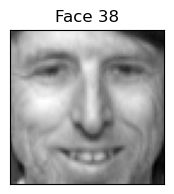

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))

for i in range(len(id_train)):
    ax.imshow(data_selected[i * 10], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Face {id_train[i]}")

In [41]:
feature_vectors = np.array(data_selected).reshape((np.array(data_selected).shape[0], 64 * 64))
feature_vectors.shape

(10, 4096)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                    random_state=42, stratify=target)
X_train.shape

(7, 4096)

### Twarz średnia

Text(0.5, 1.0, 'Twarz średni')

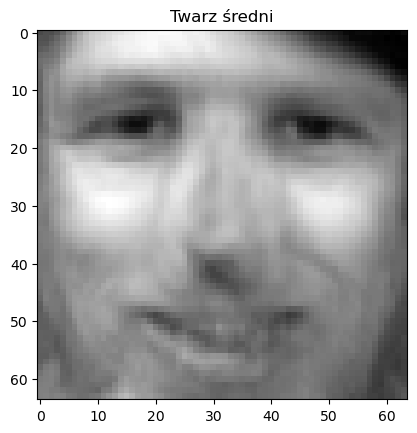

In [43]:
mean_face = np.mean(X_train, axis=0)
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title(f"Twarz średni")

### Eigenfaces 

In [44]:
feature_vectors_subtracted = X_train - mean_face
covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))
covariance_matrix.shape

(7, 7)

In [45]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
_, eigenvectors_sort = zip(*eig_pairs)
eigenvectors_sort = np.array(eigenvectors_sort)[:100]

eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
eigenfaces.shape

(7, 4096)

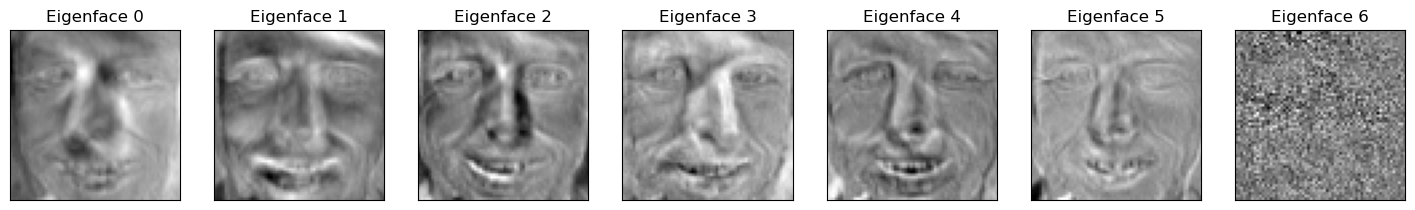

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(18, 6))
ax = ax.flatten()
for i in range(7):
    ax[i].imshow(eigenfaces[i].reshape(64, 64), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Eigenface {i}")

In [47]:
transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
transformed_faces.shape

(7, 7)

### Rozpoznawanie twarzy

epsilon zdjęcia istniejącego w bazie: 4.3110478e-07


Text(0.5, 1.0, 'Twarz odtworzona')

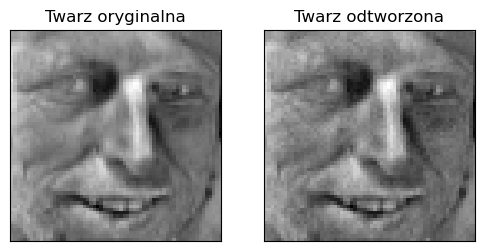

In [48]:
subtracted_vector = X_train[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon zdjęcia istniejącego w bazie: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

epsilon zdjęcia osoby istniejącej w bazie: 1.3008407


Text(0.5, 1.0, 'Twarz odtworzona')

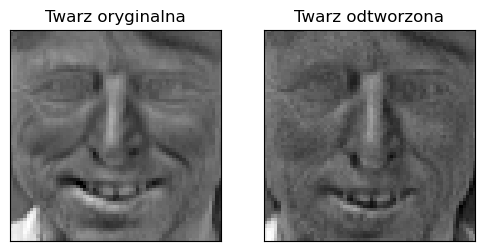

In [49]:
subtracted_vector = X_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon zdjęcia osoby istniejącej w bazie: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznanie twarzy, osoba nie istniejąca w bazie

epsilon: 7.335647


Text(0.5, 1.0, 'Twarz odtworzona')

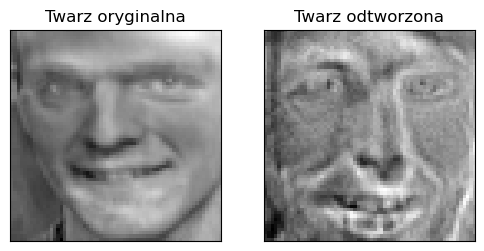

In [50]:
subtracted_vector = data_selected_test[45] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki najbliższy sąsiad

In [51]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 4

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) > theta):
        errors += 1
        continue

    if (y_train[np.argmin(epsilon)] != y_test[i]):
        errors += 1

print(f"Statystyka: {len(y_test) - errors}/{len(y_test)} poprawnych")

Statystyka: 2/3 poprawnych


### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki K najbliższych sąsiadów

In [52]:
errors = 0

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))
    
    epsilon_sorted_indexes = np.argsort(epsilon)[:7]
    values = [y_train[index] for index in epsilon_sorted_indexes]
    
    counts = Counter(values)
    max_count = max(counts.values())
   
    if max_count >= 4:
        for value, count in counts.items():
            if count == max_count:
                if(value != y_test[i]):
                    errors +=1
    else:
        errors +=1 
                    
print(f"Statystyka: {len(y_test)-errors}/{len(y_test)} poprawnych") 

Statystyka: 3/3 poprawnych


### Rozpoznawanie twarzy (osoba nieistniejąca w bazie) - statystyki najbliższy sąsiad

In [53]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 4

for i, face in enumerate(data_selected_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) < theta):  
        errors += 1

print(f"Statystyka: {len(target_test) - errors}/{len(target_test)} poprawnych")

Statystyka: 387/390 poprawnych


### Walidacja przez wszystkie twarze

In [54]:
data = np.load("./olivetti_faces.npy")

unique_ids = [i for i in range(40)]

errors = 0
new_errors = 0

for unique_id in unique_ids:
    data_selected = []
    for i in range(10):
        data_selected.append(data[unique_id*10+i])
        
    target = []
    target.extend([unique_id for _ in range(10)])
        
        
    data_selected_test = []    
    for i in unique_ids:
        if i == unique_id:
            continue
        for j in range(10):
            data_selected_test.append(data[i*10+j])
        
    data_selected_test = np.array(data_selected_test).reshape((np.array(data_selected_test).shape[0], 64 * 64))
    
    target_test = []
    for i in unique_ids:
        if i == unique_id:
            continue
        target_test.extend([i for _ in range(10)])
        
    # trenowanie 
    feature_vectors = np.array(data_selected).reshape((np.array(data_selected).shape[0], 64 * 64))
    X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                        random_state=42, stratify=target)

    mean_face = np.mean(X_train, axis=0)
    feature_vectors_subtracted = X_train - mean_face
    covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
    _, eigenvectors_sort = zip(*eig_pairs)
    eigenvectors_sort = np.array(eigenvectors_sort)[:100]

    eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
    transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
    

    temp_norms = []
    for i in transformed_faces:
        for j in transformed_faces:
            temp_norms.append(np.linalg.norm(i - j))

    theta = max(temp_norms) / 4

    for i, face in enumerate(X_test):
        subtracted_vector = face - mean_face
        projected_vector = np.dot(eigenfaces, subtracted_vector)

        epsilon = []
        for face in transformed_faces:
            epsilon.append(np.linalg.norm(projected_vector - face))

        if (min(epsilon) > theta):
            errors += 1
            continue

        if (y_train[np.argmin(epsilon)] != y_test[i]):
            errors += 1
            
        temp_norms = []
        for i in transformed_faces:
            for j in transformed_faces:
                temp_norms.append(np.linalg.norm(i - j))

        theta = max(temp_norms) / 4

        for i, face in enumerate(data_selected_test):
            subtracted_vector = face - mean_face
            projected_vector = np.dot(eigenfaces, subtracted_vector)

            epsilon = []
            for face in transformed_faces:
                epsilon.append(np.linalg.norm(projected_vector - face))

            if (min(epsilon) < theta):  
                new_errors += 1


print(f"Statystyka najbliższy sąsiad: {len(y_test)*len(unique_ids) - errors}/{len(y_test)*len(unique_ids)} poprawnych")
print(f"Statystyka nowe najbliższy sąsiad: {len(data_selected_test)*len(unique_ids) - new_errors}/{len(data_selected_test)*len(unique_ids)} poprawnych")

Statystyka najbliższy sąsiad: 50/120 poprawnych
Statystyka nowe najbliższy sąsiad: 13831/15600 poprawnych
